# Periodgram Smoothing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
#pip freeze > requirements.txt

# Primer boludeo con AR(1) para ganar feeling

In [3]:
""" total_points = 3000

A = 0.7
den = [1, -A]
num = [1]
ar_sys = signal.TransferFunction(num, den, dt = 1)

mean = 0
std = 1
e = np.random.normal(mean, std, total_points)

tout, yout = signal.dlsim(ar_sys, e)

plt.figure()

#plt.plot(tout, yout, linestyle='-', color='b')
plt.plot(tout, e, linestyle='-', color='r')
plt.title('Gaussian Random Sequence Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show() """



" total_points = 3000\n\nA = 0.7\nden = [1, -A]\nnum = [1]\nar_sys = signal.TransferFunction(num, den, dt = 1)\n\nmean = 0\nstd = 1\ne = np.random.normal(mean, std, total_points)\n\ntout, yout = signal.dlsim(ar_sys, e)\n\nplt.figure()\n\n#plt.plot(tout, yout, linestyle='-', color='b')\nplt.plot(tout, e, linestyle='-', color='r')\nplt.title('Gaussian Random Sequence Over Time')\nplt.xlabel('Time')\nplt.ylabel('Value')\nplt.grid(True)\nplt.show() "

In [4]:
""" corr = np.correlate(yout[:, 0], yout[:, 0], mode = 'full')
ryy_biased = corr / total_points
ryy_unbiased_normalized = np.array([corr[x] / (total_points - np.abs(total_points-1 - x)) for x in range(0, len(corr))]) /  ryy_biased[total_points-1]
ryy_biased_normalized = ryy_biased /  ryy_biased[total_points-1]
n = np.arange(0, total_points+1)
ryy_teo = pow(A, n)

plt.plot(np.arange(-(total_points-1), total_points), ryy_biased_normalized, linestyle='-', color='b')
#plt.plot(np.arange(-(total_points-1), total_points), ryy_unbiased_normalized, linestyle='-', color='g')
plt.plot(n, ryy_teo, linestyle='-', color='r')
plt.title('biased vs teorico AR(1)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.xlim(-150, 150)
plt.show() """

" corr = np.correlate(yout[:, 0], yout[:, 0], mode = 'full')\nryy_biased = corr / total_points\nryy_unbiased_normalized = np.array([corr[x] / (total_points - np.abs(total_points-1 - x)) for x in range(0, len(corr))]) /  ryy_biased[total_points-1]\nryy_biased_normalized = ryy_biased /  ryy_biased[total_points-1]\nn = np.arange(0, total_points+1)\nryy_teo = pow(A, n)\n\nplt.plot(np.arange(-(total_points-1), total_points), ryy_biased_normalized, linestyle='-', color='b')\n#plt.plot(np.arange(-(total_points-1), total_points), ryy_unbiased_normalized, linestyle='-', color='g')\nplt.plot(n, ryy_teo, linestyle='-', color='r')\nplt.title('biased vs teorico AR(1)')\nplt.xlabel('Time')\nplt.ylabel('Value')\nplt.grid(True)\nplt.xlim(-150, 150)\nplt.show() "

In [5]:
""" plt.plot(np.arange(-(total_points-1), total_points), ryy_biased_normalized, linestyle='-', color='b')
plt.plot(np.arange(-(total_points-1), total_points), ryy_unbiased_normalized, linestyle='-', color='g')
plt.title('biased vs unbiased')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.xlim(1500, 3000)
plt.show() """

" plt.plot(np.arange(-(total_points-1), total_points), ryy_biased_normalized, linestyle='-', color='b')\nplt.plot(np.arange(-(total_points-1), total_points), ryy_unbiased_normalized, linestyle='-', color='g')\nplt.title('biased vs unbiased')\nplt.xlabel('Time')\nplt.ylabel('Value')\nplt.grid(True)\nplt.xlim(1500, 3000)\nplt.show() "

# Listo con el boludeo
----


# Periodogram classic

In [6]:
from scipy import fft

def periodogram(x, N_FFT):
    w = fft.fftshift(fft.fftfreq(N_FFT, d=1.0)) * 2 * np.pi
    periodogram = np.abs(fft.fftshift(fft.fft(x, n = N_FFT)))**(2) / len(x) 
    return periodogram, w 


In [7]:
def biased_autocorr(x): 
    corr = np.correlate(x, x, mode = 'full')
    rxx_biased = corr / len(x)
    return rxx_biased

def unbiased_autocorr(x):
    corr = np.correlate(x, x, mode = 'full')
    rxx_unbiased = np.array([corr[n] / (len(x) - np.abs(len(x) - 1 - n)) for n in range(0, len(corr))])
    return rxx_unbiased

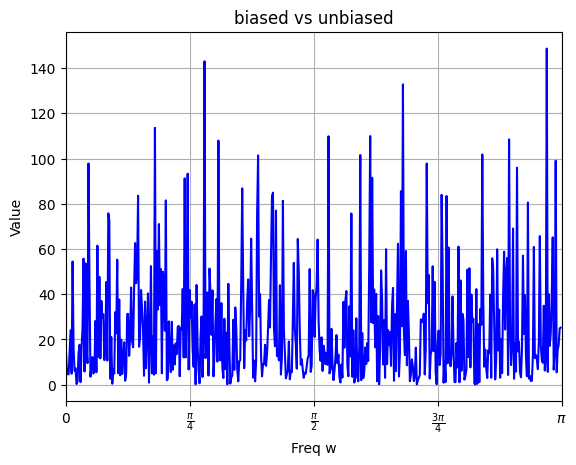

In [8]:
mean = 0
std = 5
noise = np.random.normal(mean, std, 1000) # Ruido blanco gaussiano

p, w = periodogram(noise, 1000)

plt.plot(w, p, linestyle='-', color='b')
plt.title('biased vs unbiased')
plt.xlabel('Freq w')
plt.ylabel('Value')
pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)
pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
plt.xticks(pi_ticks, pi_labels)
plt.xlim(0, np.pi)
plt.grid(True)
plt.show()

25.31388544349858
25.343540548735245


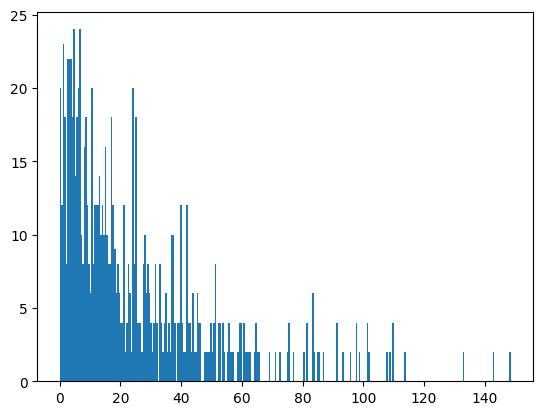

In [9]:
plt.hist(p, bins = 300)
print(np.std(p))
print(np.mean(p))

**NOTAR QUE EL STD DA LO MISMO QUE LO QUE DICE LA TEORIA, AUNQUE NO ES UNA GAUSSIANA**
---
Ahora veamos la performance del biased y unbiased

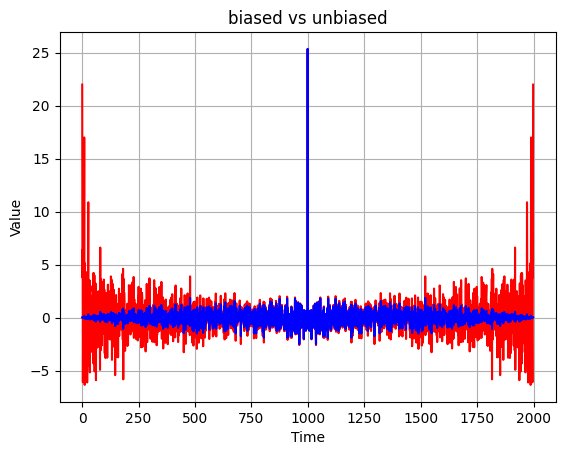

In [10]:
x = biased_autocorr(noise)
y = unbiased_autocorr(noise)
plt.plot(y, linestyle='-', color='r')
plt.plot(x, linestyle='-', color='b')
plt.title('biased vs unbiased')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

**Notar el efecto del ruido amplicado**

# Periodogram Smoothing

In [11]:
# x: datos de tamaño N
# L: Siendo (L-1) tamaño del lag máximo de autocorrelación i.e. Rxx(l > |L-1|) = 0
# N_FFT: La cantidad de puntos que se usa en la FFT para visualizar el periodograma. Notar que en clase solemos hacerlo con N, pero podemos
# usar un valor mas chico a N para no hacerlo tan pesado al plot, aunque siempre debe ser mas grande que 2L-1 claramente. 
# Elegir N_FFT != N no "cambia" nada, simplemente se interpola con menos puntos
def periodogram_smoothing(x, L, N_FFT):

    if N_FFT < 2*L-1:
        raise Exception("N_FFT < len(x)")     

    N = len(x)
    rxx = biased_autocorr(x) # 2N - 1 de largo
    offset = N - 1 
    rxx = rxx[offset - (L-1) : offset + (L-1) + 1] # autocorr ventaneada o windowed con L
    window = signal.get_window(window="bartlett", Nx=2*L-1, fftbins= False) 
    rxx_windowed = rxx*window

    Rxx = np.abs(fft.fftshift(fft.fft(rxx_windowed, n = N_FFT))) # (*) ver MARKDOWN ABAJO
    w = fft.fftshift(fft.fftfreq(N_FFT, d=1.0)) * 2 * np.pi

    return Rxx, w


(*) No deberia ser necesario aplicar abs, dado que siempre es positiva la ventana triangular o la de parzen, pero dado que contiene componentes imaginarias el abs debera ser aplicado. La DTFT sobre la triangular no aparece complejos, pero la DFT se puede pensar como un muestreo de la DTFT, pero SHIFTEADO en tiempo, (ver definicion de DFT), este shifteo en tiempo en frecuencia le agrega un fasor complejo, que no afecta el modulo, pero te mete complejos. 

2000


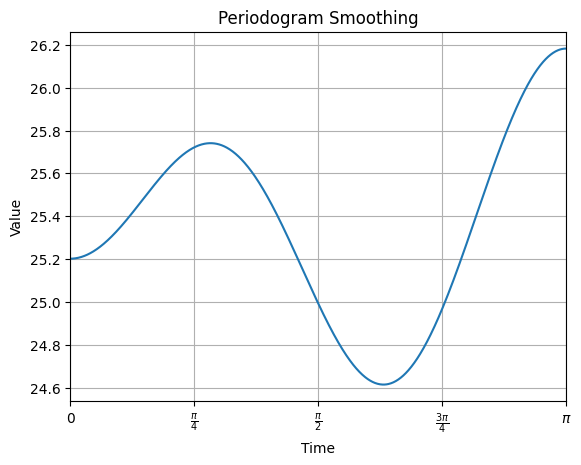

In [12]:
Rxx, w = periodogram_smoothing(noise[0:1000], 5, 2000)

print(len(Rxx))
# plt.plot(rxx)
# plt.plot(window)
plt.plot(w, Rxx)

plt.title('Periodogram Smoothing')

pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)
pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
plt.xticks(pi_ticks, pi_labels)
plt.xlabel('Time')
plt.ylabel('Value')
plt.xlim(0, np.pi)
plt.grid(True)
plt.show()

In [13]:
def pulse(n, M):
    return np.array([1 if (np.abs(nVal) <= (M-1)/2) else 0 for nVal in n])

# Periodogram Averaging

In [14]:
def periodogram_averaging(x, L, D, N_FFT): # procurar que N_FFT > 2L-1
    N = len(x)
    num_segmentos = (N - L)//D      # Cantidad de segmentos con largo L
    Rx = np.zeros(N_FFT)
    for i in range(0, num_segmentos):
        x_seg = x[i*D : i*D + L]
        Rx += 1/L * np.abs(fft.fftshift(fft.fft(x_seg, N_FFT)))**2

    Rx = Rx/num_segmentos
    w = fft.fftshift(fft.fftfreq(N_FFT, d=1.0)) * 2 * np.pi
    return Rx, w

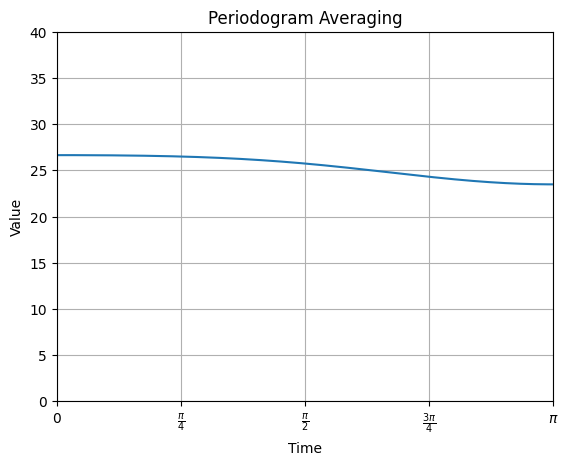

In [15]:
Rxx, w = periodogram_averaging(noise, 4, 4, 1000)

plt.plot(w, Rxx)
plt.title('Periodogram Averaging')

pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)
pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
plt.xticks(pi_ticks, pi_labels) 

plt.xlabel('Time')
plt.ylabel('Value')
plt.ylim(0,40)
plt.xlim(0, np.pi)
plt.grid(True)
plt.show()

# DATASET L1 32 SEC 4K

In [16]:
import h5py

def dump_info(name, obj):
    print("{0} :".format(name))
    try:
        print("   .value: {0}".format(obj[()]))
        for key in obj.attrs.keys():
            print("     .attrs[{0}]:  {1}".format(key, obj.attrs[key]))
    except:
        pass

filename = 'H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5'
file = h5py.File(filename, 'r')
file.visititems(dump_info)



meta :
meta/Description :
   .value: b'Strain data time series from LIGO'
meta/DescriptionURL :
   .value: b'http://www.gw-openscience.org/'
meta/Detector :
   .value: b'H1'
meta/Duration :
   .value: 32
meta/GPSstart :
   .value: 1126259447
meta/Observatory :
   .value: b'H'
meta/Type :
   .value: b'StrainTimeSeries'
meta/UTCstart :
   .value: b'2015-09-14T09:50:30'
quality :
quality/detail :
quality/injections :
quality/injections/InjDescriptions :
   .value: [b'Passes NO_CBC_HW_INJ test' b'Passes NO_BURST_HW_INJ test'
 b'Passes NO_DETCHAR_HW_INJ test' b'Passes NO_CW_HW_INJ test'
 b'Passes NO_STOCH_HW_INJ test']
quality/injections/InjShortnames :
   .value: [b'NO_CBC_HW_INJ' b'NO_BURST_HW_INJ' b'NO_DETCHAR_HW_INJ' b'NO_CW_HW_INJ'
 b'NO_STOCH_HW_INJ']
quality/injections/Injmask :
   .value: [31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31]
     .attrs[Bits]:  5
     .attrs[Description]:  A bitmask encoded as an integer-valued timeseries

In [17]:
dset = file['strain/Strain'][()]
fs = 1 / file['strain/Strain'].attrs['Xspacing']
print(fs)

4096.0


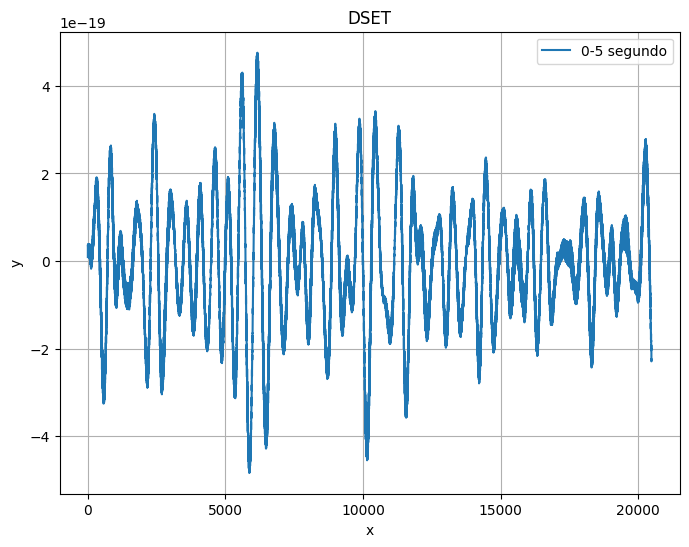

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(dset[int(0*fs): int(5*fs)], label='0-5 segundo')
plt.title('DSET')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


Evento es considerado que ocurre entre 14 y 20 segundos

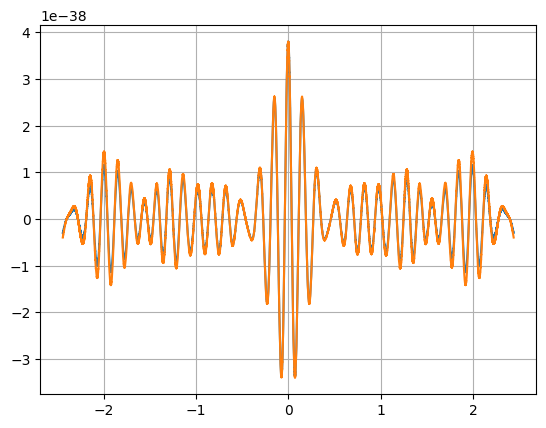

In [19]:

noise1 = dset[:int(14*fs)]
noise2 = dset[int(20*fs):int(32*fs)-1]
L = 10000
N = L*4
L_2 = L
offset = N - 1 
plt.cla()
rxx = biased_autocorr(noise1[:N] - np.mean(noise1[:N]))
rxx_un = unbiased_autocorr(noise1[:N] - np.mean(noise1[:N]))

rxx = rxx[offset - (L_2-1) : offset + (L_2-1) + 1] # autocorr ventaneada o windowed con L
rxx_un = rxx_un[offset - (L_2-1) : offset + (L_2-1) + 1]
lags = np.arange(-(L_2-1), (L_2-1) + 1) / fs
#f = 4*np.sinc(lags/30e-3)*1e-38
#plt.plot(lags, f)
plt.plot(lags, rxx)
plt.plot(lags, rxx_un)
plt.grid(True)
plt.show()
# plt.figure()

# Periodograma comúm

In [20]:
%matplotlib ipympl

Segundos de L =  2.0
Segundos de N =  12.0
Size N =  49152


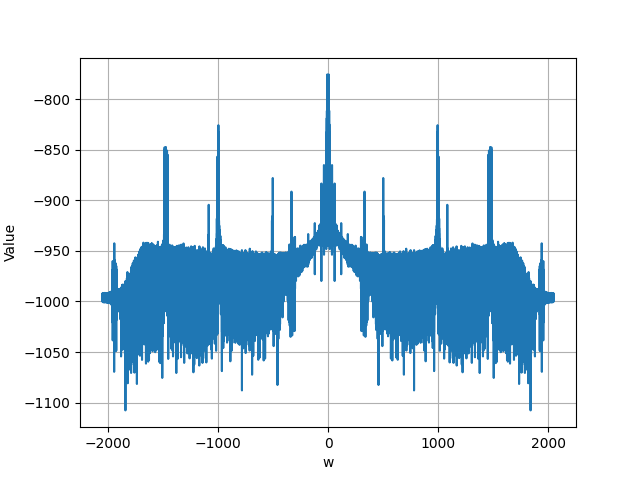

In [21]:

noise1 = dset[:int(14*fs)]

L_seg = 2
L = int(L_seg*fs)
print('Segundos de L = ', L/fs)
N = L*6
print('Segundos de N = ', N/fs)
print('Size N = ', N)

plt.figure()
noisea = noise1[0:N]
Rxx, w = periodogram(noisea, 1000000)
plt.cla()
w = w * fs / (2*np.pi)
plt.plot(w, 10*np.log(Rxx))
#pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)*fs/(2*np.pi)
#pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
#plt.xticks(pi_ticks, pi_labels)
plt.xlabel('w')
plt.ylabel('Value')
#plt.xlim(0, np.pi)
plt.grid(True)
plt.show()

# Periodogram Smoothing

Segundos de L =  1.0
Numero de samples de L =  4096
Segundos de N =  14.0
Size N =  57344
Resolucion Espectral en Hz 2.0


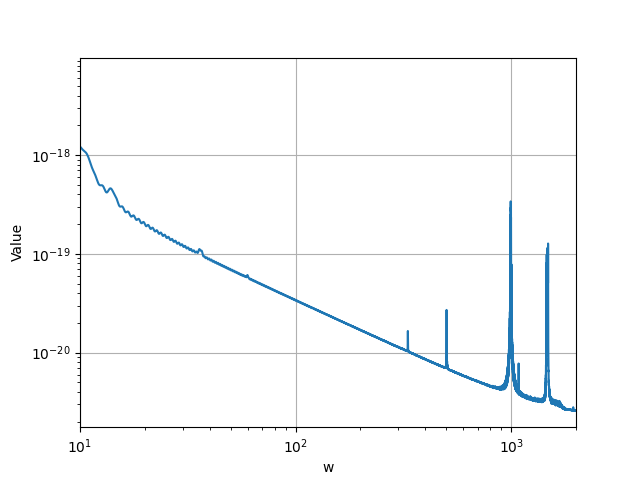

In [23]:
noise1 = dset[:int(14*fs)]

L_seg = 1
L = int(L_seg*fs)
print('Segundos de L = ', L/fs)
print('Numero de samples de L = ', L)
N = int(fs*14)
print('Segundos de N = ', N/fs)
print('Size N = ', N)
print('Resolucion Espectral en Hz', 2/L_seg)
noisea = noise1[0:N]
plt.figure()
try:
    Rxx, w = periodogram_smoothing(noisea, L, N)
except CustomException as e:
    print("Custom exception caught:", e)

plt.cla()
w = w * fs / (2*np.pi)
plt.xscale('log')
plt.yscale('log')
plt.plot(w, Rxx**(1/2))
#pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)*fs/(2*np.pi)
#pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
#plt.xticks(pi_ticks, pi_labels)
plt.xlabel('w')
plt.ylabel('Value')
plt.xlim(10, 2000)
#plt.ylim(-850, -750)
#plt.xlim(0, np.pi)
plt.grid(True)
plt.show()

In [24]:
event_time = 1126259462
start_time = file['quality/injections/Injmask'].attrs['Xstart']
te = int((event_time-start_time)*fs)
event_samples = dset[te-int(1*fs):te+int(1*fs)]

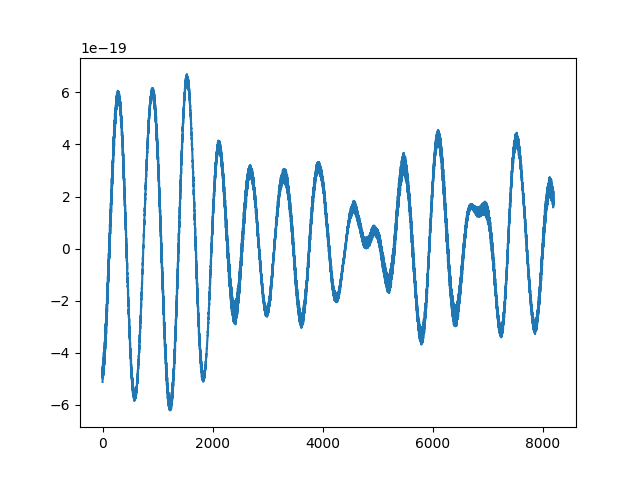

In [25]:
plt.figure()
plt.plot(event_samples)
plt.show()

In [26]:
""" from IPython.display import Audio

Nt = len(event_samples)
# take the fourier transform of the data
freqs = np.fft.fftfreq(Nt, 1)
dwindow = signal.get_window(window="bartlett", Nx=Nt, fftbins= False) 
# whitening: transform to freq domain, divide by square root of psd, then
# transform back, taking care to get normalization right.
hf = np.fft.fft(event_samples*dwindow)
norm = 1./np.sqrt(1./(1*2))
white_hf = hf / np.sqrt(Rxx) * norm
white_ht = np.fft.ifft(white_hf, n=Nt)


plt.figure()
plt.cla()

plt.plot( (white_ht - np.mean(white_ht))/ np.max((white_ht - np.mean(white_ht))) , color = 'r')
plt.plot( (event_samples - np.mean(event_samples))/ np.max((event_samples - np.mean(event_samples))), color = 'b' )

Audio((white_ht - np.mean(white_ht))/ np.max((white_ht - np.mean(white_ht))), rate=fs)
#pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)*fs/(2*np.pi)
#pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
#plt.xticks(pi_ticks, pi_labels)
plt.xlabel('w')
plt.ylabel('Value')
#plt.xlim(100, 1000)
#plt.ylim(-850, -750)
#plt.xlim(0, np.pi)
plt.grid(True)
plt.show() """

ValueError: operands could not be broadcast together with shapes (8192,) (57344,) 

ValueError: x and y must have same first dimension, but have shapes (57344,) and (8192,)

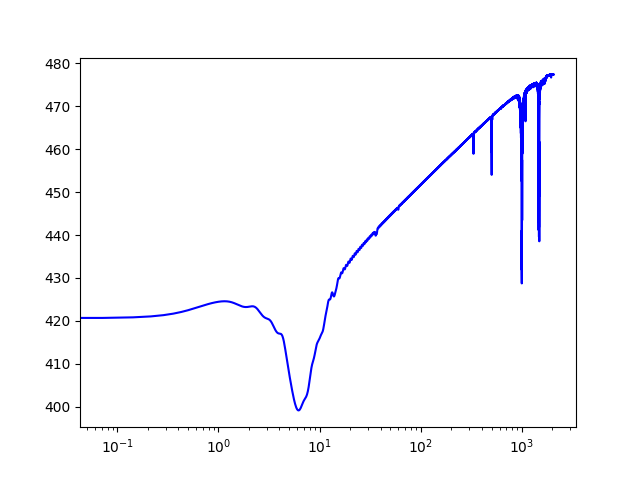

In [27]:
""" plt.figure()
plt.cla()
plt.xscale('log')
plt.plot(w, 10*np.log(1 / np.sqrt(Rxx) * norm), color = 'b')
plt.plot(w, 10*np.log(np.abs(hf)), color = 'r')
#pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)*fs/(2*np.pi)
#pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
#plt.xticks(pi_ticks, pi_labels)
plt.xlabel('w')
plt.ylabel('Value')
#plt.xlim(0, 40)
#plt.ylim(-850, -750)
#plt.xlim(0, np.pi)
plt.grid(True)
plt.show() """

In [ ]:
""" Audio((white_ht - np.mean(white_ht))/ np.max((white_ht - np.mean(white_ht))), rate=fs)
 """

In [ ]:
""" Audio((event_samples - np.mean(event_samples))/ np.max((event_samples - np.mean(event_samples))), rate=fs)
 """

In [ ]:
""" import numpy as np
from IPython.display import Audio

# Parameters for the sine wave
frequency = 440  # Frequency of the sine wave in Hz (A4)
duration = 3     # Duration of the sound in seconds
sample_rate = 44100  # Sample rate in Hz

# Generate the time values
t = np.linspace(0, duration, int(sample_rate * duration))

# Generate the sine wave audio data
audio_data = 0.5 * np.sin(2 * np.pi * frequency * t)

# Play the sine wave sound
audio = Audio(data=audio_data, rate=sample_rate)
display(audio)
 """

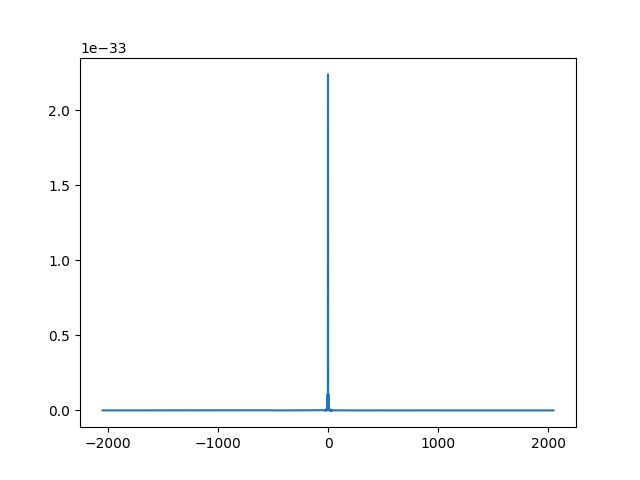

In [ ]:
""" plt.figure()
plt.plot(w, Rxx) """

# Periodogram Averaging

Segundos de L =  6.0
Segundos de N =  36.0
Size N =  147456


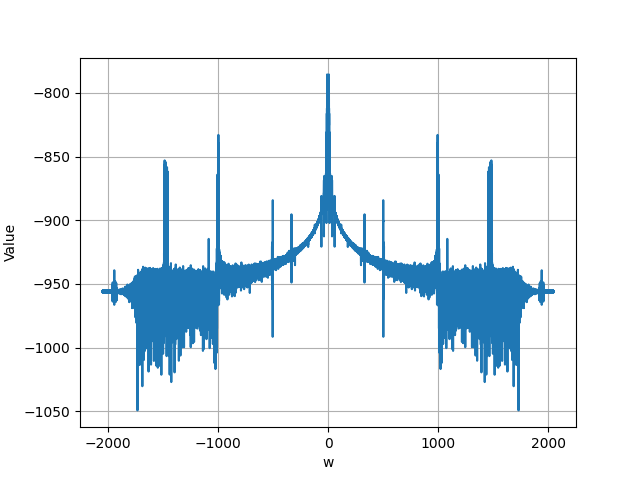

In [28]:
noise1 = dset[:int(14*fs)]

L_seg = 6
L = int(L_seg*fs)
print('Segundos de L = ', L/fs)
N = L*6
print('Segundos de N = ', N/fs)
print('Size N = ', N)

plt.figure()
noisea = noise1[0:N]
Rxx, w = periodogram_averaging(noisea, L, L, N)
plt.cla()
w = w * fs / (2*np.pi)
plt.plot(w, 10*np.log(Rxx))
#pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)*fs/(2*np.pi)
#pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
#plt.xticks(pi_ticks, pi_labels)
plt.xlabel('w')
plt.ylabel('Value')
#plt.xlim(0, np.pi)
plt.grid(True)
plt.show()

$$
    \Delta \omega \approx \frac{2\pi}{N}\cdot (2L+1)
$$

Para ventana triangular  ANCHO LOBULO = $4\pi/L$ radianes
ANCHO LOBULO HZ =  $2/L$ * fs = 4096 * 2 / 1 = 2Hz


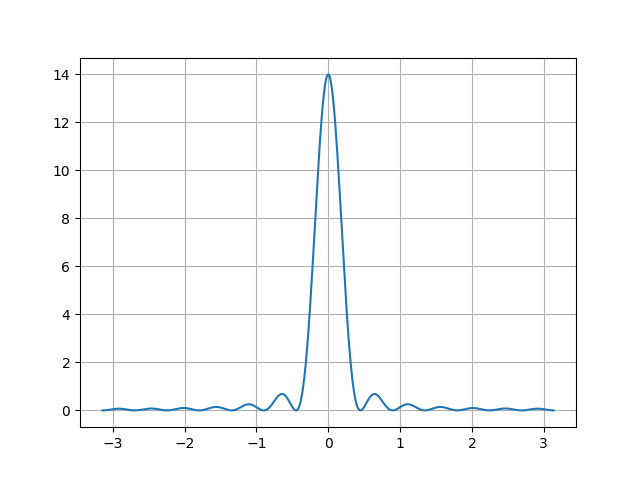

In [29]:
L = 15
window = signal.get_window(window="bartlett", Nx=2*L-1, fftbins= False) 
N_FFT = 1000
Rxx = np.abs(fft.fftshift(fft.fft(window, n = N_FFT)))
w = fft.fftshift(fft.fftfreq(N_FFT, d=1.0)) * 2 * np.pi
plt.figure()
plt.grid()
plt.plot(w, Rxx)
plt.show()